<a href="https://colab.research.google.com/github/kevalya-kumar/speech-emotion-recognization-project/blob/main/ser_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
kartik2khandelwal_speech_emotion_dataset_path = kagglehub.dataset_download('kartik2khandelwal/speech-emotion-dataset')

print('Data source import complete.')


100%|██████████| 763k/763k [00:00<00:00, 17.0MB/s]

Extracting files...
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Importing required libraries

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

## Data path

In [ ]:
csv = '/content/archive.zip'
Features = pd.read_csv(csv)

## Looking into the data

In [ ]:
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-637.701233,104.299019,4.894947,20.494011,12.552954,2.851410,-6.633390,-4.091278,-10.423918,-6.406950,...,0.172893,-1.170210,-5.292450,-0.573319,1.019471,-3.492607,-3.468123,-1.214944,1.971239,male_calm
1,-596.908460,86.871936,9.470162,17.109819,11.198966,1.541056,-6.677264,-5.755428,-9.684472,-6.891256,...,0.033803,-1.986515,-5.103855,-1.253110,0.514896,-3.268317,-4.502895,0.167153,0.256732,male_calm
2,-698.086548,99.795929,1.892679,19.915264,7.532868,1.265761,-9.188656,-5.798194,-12.299710,-4.976400,...,-1.639542,-2.603761,-4.890347,-0.879222,-1.250208,-3.449960,-4.708529,-0.086224,-3.034044,male_calm
3,-279.141052,41.092949,-21.319229,7.802911,-13.140503,-9.407660,-15.580647,-6.097223,-24.700903,-9.640293,...,-10.305976,-4.092835,-5.817179,-10.731523,-0.823596,-15.885103,-2.014258,-6.173852,-5.331760,male_angry
4,-160.074686,17.576058,-2.147436,3.133417,-4.745002,-6.510771,-5.911591,-4.481506,-9.470598,-5.907823,...,-4.088007,-1.817639,-2.994765,-4.893176,-2.880436,-7.163400,-2.147345,-2.359248,-3.746217,male_angry


**0 - 19 columns are the extracted features and can be trained to get the desired emotion.**

## One Hot Encoding and Scaling the data

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=24, shuffle=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20, 1), (3240, 16), (1080, 20, 1), (1080, 16))

## Model building

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout, Multiply, Lambda
from tensorflow.keras import backend as K
import tensorflow.keras as keras

# Define input
inputs = Input(shape=(x_train.shape[1], 1))

x = Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
x = BatchNormalization()(x)

x = LSTM(256, return_sequences=True)(x)
x = LSTM(128, return_sequences=True)(x)

# Attention mechanism
attention = Dense(1, activation='tanh')(x)
attention = Dense(1, activation='softmax')(attention)
attention = Multiply()([x, attention])
attention = Lambda(lambda x: K.sum(x, axis=1))(attention)

x = Dense(128, activation='relu')(attention)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(16, activation='softmax')(x)

# Define model
model = Model(inputs=inputs, outputs=outputs)

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 20, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 20, 2048)       │         12,288 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_6           │ (None, 10, 2048)       │              0 │ conv1d_6[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 10, 2048)       │          8,192 │ max_pooling1d_6[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 10, 1024)       │     10,486,784 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_7           │ (None, 5, 1024)        │              0 │ conv1d_7[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 5, 1024)        │          4,096 │ max_pooling1d_7[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 5, 512)         │      2,621,952 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_8           │ (None, 3, 512)         │              0 │ conv1d_8[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 3, 512)         │          2,048 │ max_pooling1d_8[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 3, 256)         │        787,456 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 3, 128)         │        197,120 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 3, 1)           │            129 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 3, 1)           │              2 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 3, 128)         │              0 │ lstm_5[0][0],          │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)      

 Total params: 14,147,443 (53.97 MB)

 Trainable params: 14,140,275 (53.94 MB)

 Non-trainable params: 7,168 (28.00 KB)

## Callback

In [ ]:
# rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
# history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

history = model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test))

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 3, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.0710 - loss: 2.7788 - val_accuracy: 0.0528 - val_loss: 2.7700
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1059 - loss: 2.7139 - val_accuracy: 0.0722 - val_loss: 2.7646
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.1129 - loss: 2.6695 - val_accuracy: 0.0944 - val_loss: 2.7490
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.1448 - loss: 2.6011 - val_accuracy: 0.0694 - val_loss: 2.7516
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.1732 - loss: 2.5020 - val_accuracy: 0.1296 - val_loss: 2.6628
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.1741 - loss: 2.4647 - val_accuracy: 0.1259 - val_loss: 2.6535
Epoch 7/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2121 - loss: 2.3364 - val_accuracy: 0.0917 - val_loss: 2.6935
Epoch 8/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2428 - loss: 2.2632 - val_accuracy: 0.1481 - val_l

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8289 - loss: 1.2128
Accuracy of our model on test data :  82.4999988079071 %


## Plotting train and test loss and accuracy

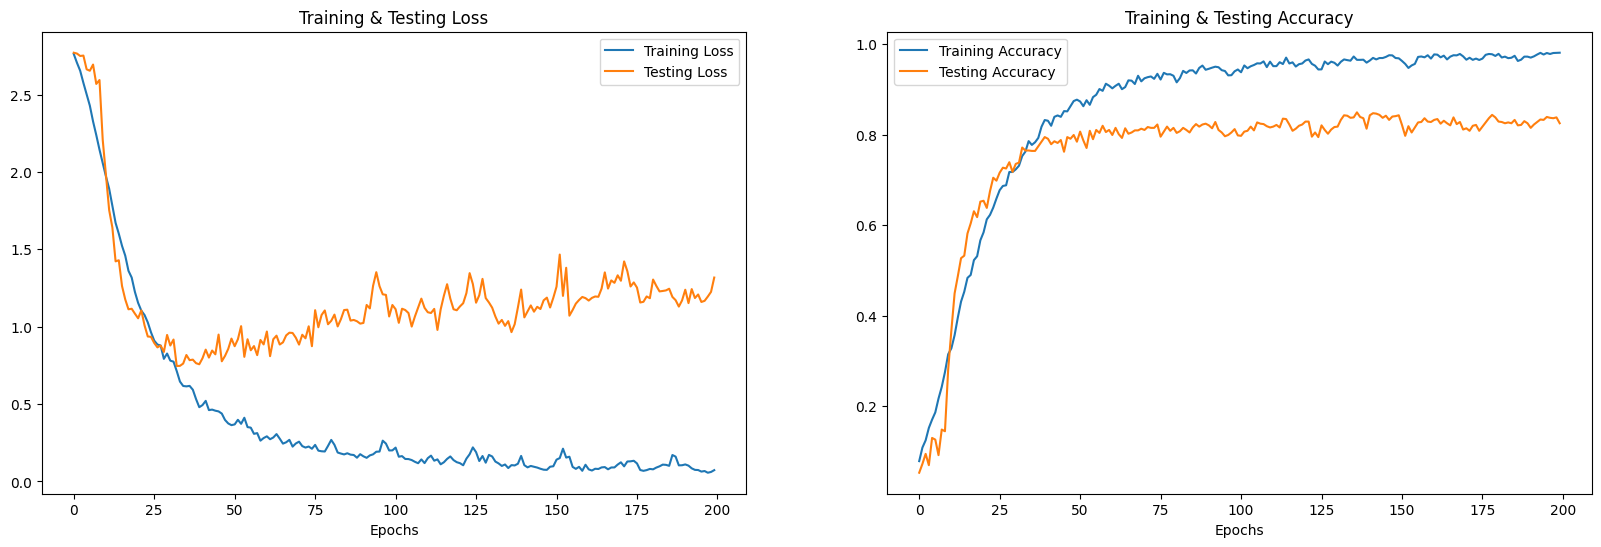

In [ ]:
epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 3, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


,Predicted Labels,Actual Labels
0,female_neutral,female_fear
1,female_calm,female_calm
2,male_angry,male_fear
3,female_surprise,female_surprise
4,female_disgust,female_happy
5,male_disgust,male_disgust
6,male_fear,male_fear
7,female_fear,female_fear
8,female_sad,female_surprise
9,male_surprise,male_surprise


## Confusion Matrix

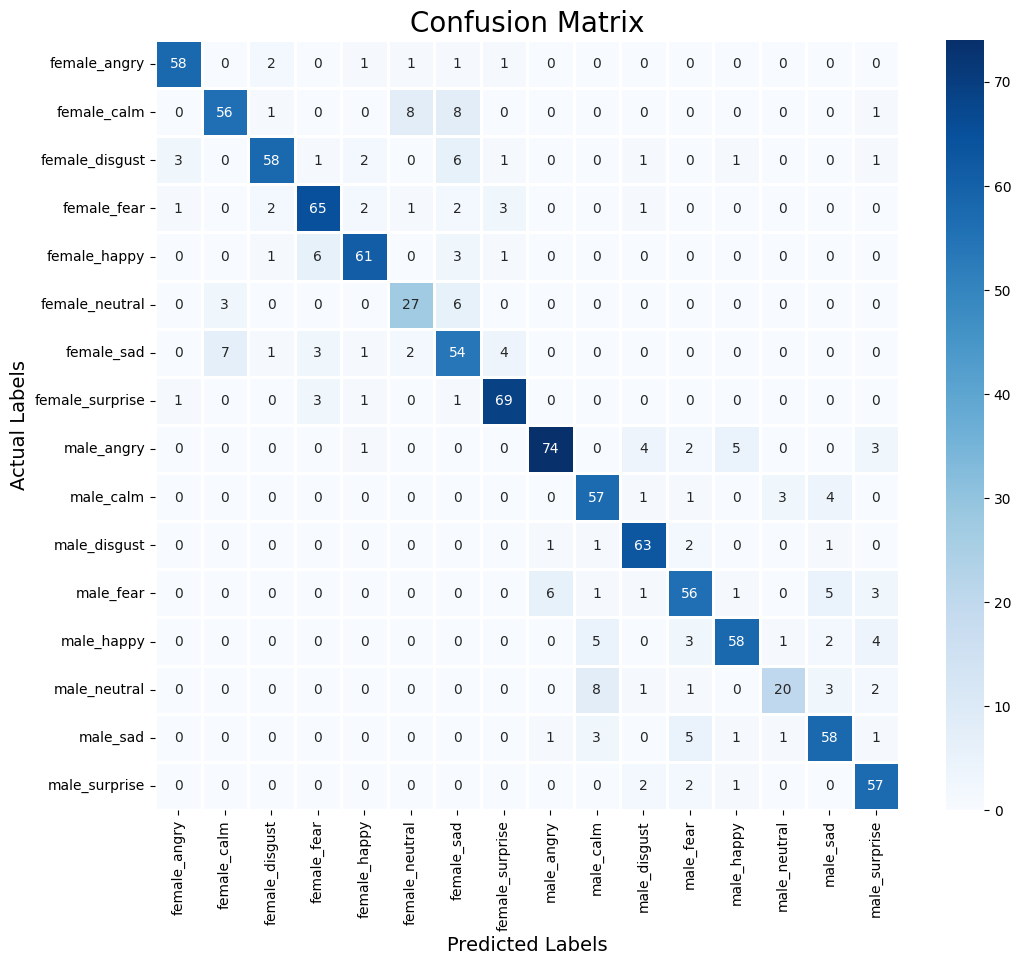

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()